In [2]:
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline   
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [25]:
data = pd.read_csv("./processed_data/prcessed_factor.csv")
data.head()

,index,ts_code,trade_date,lreturn,adjustment_return,pe,pb,return_1m,return_2m,return_3m,return_6m,return_12m,wgt_return_1m,wgt_return_2m,wgt_return_3m,wgt_return_6m,wgt_return_12m,high_low_1m,high_low_2m,high_low_3m,high_low_6m,high_low_12m,std_1m,std_2m,std_3m,std_6m,std_12m,ln_price,turnover_1m,turnover_2m,turnover_3m,turnover_6m,turnover_12m,size_factor,交通运输,休闲服务,传媒,公用事业,农林牧渔,化工,医药生物,商业贸易,国防军工,家用电器,建筑材料,建筑装饰,房地产,有色金属,机械设备,汽车,电子,电气设备,纺织服装,综合,计算机,轻工制造,通信,采掘,钢铁,银行,非银金融,食品饮料
0,0,000004.SZ,2012-12-31,0.130470,0.141046,1.996230,3.979733,-0.172561,-0.473403,-0.226881,-1.152875,0.444488,-0.087168,-0.386983,0.021490,0.452009,1.018027,0.769040,0.232829,-0.143345,1.365580,-0.266724,-0.328021,-0.292866,-0.555503,0.288981,0.429828,-0.085758,-0.370106,-0.299810,-0.205666,1.147918,1.000726,-1.449779,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,000006.SZ,2012-12-31,0.110800,0.116656,-0.450992,-0.376465,1.378235,1.311841,1.703138,0.017758,1.373309,0.594856,1.147906,1.145457,-0.612921,0.904715,1.120769,0.580571,0.006517,0.441588,-0.175509,1.169529,0.490977,0.247830,0.158127,0.560935,-0.952574,0.020569,-0.154511,-0.234352,-0.465704,-0.471481,0.349501,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,000011.SZ,2012-12-31,0.009689,0.020791,-0.428483,0.394156,1.106483,0.770903,1.251973,0.222941,1.152738,0.579461,0.765695,0.912369,-0.970645,0.126190,1.215275,0.653886,0.061631,-0.545088,-0.277594,1.245103,0.802871,0.734107,0.595303,1.462767,-0.308372,2.661094,2.055787,1.961178,1.675401,3.546222,-0.013096,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,000014.SZ,2012-12-31,0.136475,0.152249,-0.259443,0.322485,1.634897,0.143528,0.079500,-0.390410,2.558174,0.565680,-1.179185,-1.534340,-1.169579,1.907279,2.176936,1.485574,1.080781,0.876827,0.977890,2.235252,2.078596,1.808372,2.396185,2.367640,-0.023602,3.041164,2.096364,2.243298,3.745683,3.773879,-0.854951,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,000016.SZ,2012-12-31,0.102191,0.117428,1.115547,-1.034305,-0.567087,-0.409612,-0.162480,-0.179479,0.122139,-0.312831,0.280412,0.686222,0.857610,0.496109,-0.382093,-0.791449,-0.785659,-0.855749,-0.670511,-0.908584,-0.855098,-0.956403,-0.922056,-0.791594,-1.727085,-0.435495,-0.391940,-0.301122,-0.253195,-0.113093,-0.122128,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [60]:
def factor_effective_reg_test(data):
    trade_date_list = data['trade_date'].unique()
    test_result = pd.DataFrame(columns = ['因子','|t|均值','|t|>2占比','t均值','t均值/t标准差','因子收益率均值','因子收益率t检验'])
    for i in data.columns[4:-29]:
        reg_result = pd.DataFrame(columns = ['trade_date','factor_coef','factor_tvalues'])
        for j in trade_date_list[:]:
            # 回归数据
            temp_data = data[data.trade_date == j]
            factor = temp_data[i]
            netural_factor = temp_data[temp_data.columns[-29:]]
            x = pd.concat([factor,netural_factor],axis=1)
            y = temp_data['lreturn']
            # 回归
            model = sm.RLM(y,x)
            results = model.fit()
            df1 = pd.DataFrame({'trade_date': j,
                                'factor_coef':results.params[0],
                                'factor_tvalues':results.tvalues[0]},
                                index = [1])
            reg_result = reg_result.append(df1,ignore_index=True)
        # 检验结果
        df2 = pd.DataFrame({'因子': i,
                            '|t|均值': reg_result.factor_tvalues.abs().mean(),
                            '|t|>2占比':(reg_result.factor_tvalues.abs() >= 2).sum() / reg_result.factor_tvalues.count(),
                            't均值':reg_result.factor_tvalues.mean(),
                            't均值/t标准差':reg_result.factor_tvalues.mean() / reg_result.factor_tvalues.std(),
                            '因子收益率均值':reg_result.factor_coef.mean(),
                            '因子收益率t检验':reg_result.factor_coef.mean()/(reg_result.factor_coef.std()/(reg_result.factor_coef.count()**0.5))},
                            index = [1])
        test_result = test_result.append(df2,ignore_index=True)
    return test_result

In [63]:
test_result = factor_effective_reg_test(data)
test_result.sort_values('|t|>2占比',ascending=False)

,因子,|t|均值,|t|>2占比,t均值,t均值/t标准差,因子收益率均值,因子收益率t检验
24,turnover_2m,6.096457,0.851064,-4.581857,-0.793276,-0.008424,-7.845227
23,turnover_1m,6.619175,0.851064,-5.250164,-0.876884,-0.009613,-8.682369
20,std_6m,6.213168,0.829787,-3.292480,-0.477561,-0.006389,-4.585685
18,std_2m,6.273320,0.829787,-3.788307,-0.550823,-0.006927,-4.976543
26,turnover_6m,5.210845,0.819149,-3.510354,-0.679005,-0.006721,-6.744129
17,std_1m,6.100676,0.819149,-3.894139,-0.581944,-0.007135,-5.450150
25,turnover_3m,5.826309,0.808511,-4.163635,-0.735132,-0.007781,-7.316250
21,std_12m,5.712827,0.808511,-2.980273,-0.470568,-0.005926,-4.392170
19,std_3m,6.358225,0.808511,-3.608783,-0.510349,-0.006793,-4.737498
15,high_low_6m,5.302230,0.797872,-1.855888,-0.283450,-0.003722,-2.873371


In [70]:
# 计算IC和RankIC
def IC_Cal(data):
    trade_date_list = data['trade_date'].unique()
    IC_result = pd.DataFrame(columns = ['因子','IC均值','IC标准差','IR比率','IC>0占比','|IC|>0.02占比',
                                          'Rank_IC均值','Rank_IC标准差','Rank_IR比率','Rank_IC>0占比','|Rank_IC|>0.02占比'])
    for i in data.columns[4:-29]:
        IC_list = pd.DataFrame(columns = ['IC','Rank_IC'])
        for j in trade_date_list[:]:
            temp_df = data[data.trade_date == j]
            X = temp_df[['lreturn',i]]
            # 计算IC和RankIC
            df1 = pd.DataFrame({'IC':X.corr().iloc[0,1],
                                'Rank_IC':X.corr('spearman').iloc[0,1]},
                                index = [1])
            IC_list = IC_list.append(df1,ignore_index=True)
        # IC和Rank_IC累计曲线
        '''ax1 = plt.subplot(2,1,1)
        plt.bar(range(len(IC_list.IC)),IC_list.IC)
        plt.title('{} IC'.format(i))
        ax2 = plt.subplot(2,1,2)
        plt.bar(range(len(IC_list.Rank_IC)),IC_list.Rank_IC)
        plt.title('{} Rank_IC'.format(i))
        plt.show()'''
        # 检验结果
        df2 = pd.DataFrame({'因子': i,
                            'IC均值':IC_list.IC.mean(),
                            'IC标准差':IC_list.IC.std(),
                            'IR比率':IC_list.IC.mean()/IC_list.IC.std(),
                            'IC>0占比':(IC_list.IC > 0).sum()/IC_list.IC.count(),
                            '|IC|>0.02占比':(IC_list.IC.abs() > 0.02).sum()/IC_list.IC.count(),
                            'Rank_IC均值':IC_list.Rank_IC.mean(),
                            'Rank_IC标准差':IC_list.Rank_IC.std(),
                            'Rank_IR比率':IC_list.Rank_IC.mean()/IC_list.Rank_IC.std(),
                            'Rank_IC>0占比':(IC_list.Rank_IC > 0).sum()/IC_list.Rank_IC.count(),
                            '|Rank_IC|>0.02占比':(IC_list.Rank_IC.abs() > 0.02).sum()/IC_list.Rank_IC.count()},
                            index = [1])

        IC_result = IC_result.append(df2,ignore_index=True)
    return IC_result

In [72]:
IC_result = IC_Cal(data)
IC_result.sort_values('|IC|>0.02占比',ascending=False)

,因子,IC均值,IC标准差,IR比率,IC>0占比,|IC|>0.02占比,Rank_IC均值,Rank_IC标准差,Rank_IR比率,Rank_IC>0占比,|Rank_IC|>0.02占比
21,std_12m,-0.029866,0.159534,-0.187205,0.404255,0.957447,-0.051281,0.183003,-0.280222,0.393617,0.946809
24,turnover_2m,-0.047882,0.140716,-0.340273,0.340426,0.946809,-0.055085,0.174112,-0.316380,0.340426,0.946809
25,turnover_3m,-0.041819,0.141644,-0.295238,0.340426,0.936170,-0.050080,0.175529,-0.285310,0.361702,0.914894
26,turnover_6m,-0.031018,0.138491,-0.223974,0.382979,0.925532,-0.040287,0.172302,-0.233815,0.404255,0.925532
23,turnover_1m,-0.057644,0.139436,-0.413408,0.297872,0.925532,-0.061659,0.172107,-0.358260,0.329787,0.978723
20,std_6m,-0.032172,0.163231,-0.197097,0.393617,0.925532,-0.053481,0.183868,-0.290868,0.361702,0.936170
19,std_3m,-0.035425,0.162446,-0.218072,0.404255,0.914894,-0.057947,0.182426,-0.317647,0.351064,0.936170
17,std_1m,-0.038536,0.153390,-0.251232,0.340426,0.914894,-0.059259,0.168574,-0.351529,0.319149,0.925532
15,high_low_6m,-0.020318,0.138172,-0.147048,0.425532,0.914894,-0.036172,0.167658,-0.215748,0.393617,0.882979
27,turnover_12m,-0.022063,0.128234,-0.172052,0.382979,0.904255,-0.032685,0.163777,-0.199568,0.414894,0.936170


In [34]:
# 分层回测
def back_test(data,test_factor):
    test_factor = test_factor
    test_data = data[['ts_code','trade_date','adjustment_return',test_factor]]

    trade_date_list = test_data['trade_date'].unique()
    # 计算累计收益
    v1=[1];v2=[1];v3=[1];v4=[1];v5=[1]
    for i in trade_date_list[:]:
        temp_df = test_data[test_data.trade_date == i]        

        a1 = temp_df[temp_df[test_factor] >= temp_df[test_factor].quantile(0.8)]
        a2 = temp_df[(temp_df[test_factor] >= temp_df[test_factor].quantile(0.6)) & (temp_df[test_factor] < temp_df[test_factor].quantile(0.8))]
        a3 = temp_df[(temp_df[test_factor] >= temp_df[test_factor].quantile(0.4)) & (temp_df[test_factor] < temp_df[test_factor].quantile(0.6))]
        a4 = temp_df[(temp_df[test_factor] >= temp_df[test_factor].quantile(0.2)) & (temp_df[test_factor] < temp_df[test_factor].quantile(0.4))]
        a5 = temp_df[temp_df[test_factor] < temp_df[test_factor].quantile(0.2)]

        v1.append(v1[-1]*((a1['adjustment_return']/len(a1)).sum() + 1))
        v2.append(v2[-1]*((a2['adjustment_return']/len(a2)).sum() + 1))
        v3.append(v3[-1]*((a3['adjustment_return']/len(a3)).sum() + 1))
        v4.append(v4[-1]*((a4['adjustment_return']/len(a4)).sum() + 1))
        v5.append(v5[-1]*((a5['adjustment_return']/len(a5)).sum() + 1))

    # 计算年化收益率 年化波动率 夏普比率 最大回撤 信息比率 calmar比率
    d = {'组合1':v1,'组合2':v2,'组合3':v3,'组合4':v4,'组合5':v5}
    perfermance_list = pd.DataFrame(columns = ['投资组合','年化收益率','年化波动率','夏普比率','最大回撤','胜率'])
    for i,j in d.items():
        df1 = pd.DataFrame({'投资组合': i,
                            '年化收益率':j[-1]**(12/(len(j)-1)) - 1,
                            '年化波动率':(pd.Series(j)/pd.Series(j).shift(1) - 1).std()*(12**0.5),
                            '夏普比率':(j[-1]**(12/(len(j)-1)) - 1)/((pd.Series(j)/pd.Series(j).shift(1) - 1).std()*(12**0.5)),
                            '最大回撤':max(1 - pd.Series(j)/pd.Series(j).cummax()),
                            '胜率':len([i for i in j if i>1])/len(j)},
                            index = [1])
        perfermance_list = perfermance_list.append(df1,ignore_index=True) 

    # 分层回测
    plt.figure(figsize=(10,6))
    plt.title('{} Backtest'.format(test_factor))
    plt.plot(range(len(v1)),v1,label='Portfolio1',linewidth = 2)
    plt.plot(range(len(v1)),v2,label='Portfolio2',linewidth = 2)
    plt.plot(range(len(v1)),v3,label='Portfolio3',linewidth = 2)
    plt.plot(range(len(v1)),v4,label='Portfolio4',linewidth = 2)
    plt.plot(range(len(v1)),v5,label='Portfolio5',linewidth = 2)
    plt.legend()
    plt.ylabel('Cumulative Return')
    plt.show()
    
    return perfermance_list

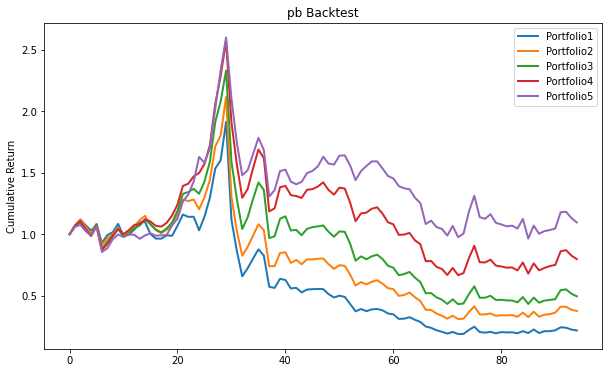

,投资组合,年化收益率,年化波动率,夏普比率,最大回撤,胜率
0,组合1,-0.176694,0.341453,-0.517478,0.900870,0.231579
1,组合2,-0.117074,0.324892,-0.360348,0.853181,0.315789
2,组合3,-0.085639,0.316876,-0.270259,0.814522,0.442105
3,组合4,-0.028354,0.293610,-0.096570,0.740411,0.600000
4,组合5,0.011803,0.270321,0.043661,0.628824,0.821053


In [35]:
perfermance_list = back_test(data,'pb')
perfermance_list